In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.io
import seaborn as sns
import pandas as pd
import re
import sys
sys.path.append('../../Metaconnectivity/Python')
from TS2dFCstream import TS2dFCstream
from dFCstream2MC import dFCstream2MC
import itertools

### Label information
SNC: super normal controls;  
NC: normal controls;  
MCI: mild cognitive impairments;  
AD: alzheimer's disease;  

In [3]:
# load groups subtab from mega_table.xlsx from data4project using pandas
group_caseid = pd.read_excel('../../data4project/mega_table.xlsx', sheet_name='groups')
print(group_caseid)
# read txt file sub_id.txt
id_aal_512 = np.loadtxt('./sub_id.txt', dtype='str')
labels = []
for index, id in enumerate(id_aal_512[:74]):
    if id in group_caseid['caseid'].to_list():
        labels.append((group_caseid["group"][index], id))

    number group caseid
0        1   SNC  2820A
1        2   SNC  3168A
2        3   SNC  3358A
3        4   SNC  3610A
4        5   SNC  4073A
..     ...   ...    ...
69      70    AD  3255A
70      71    AD  4612A
71      72    AD  5368A
72      73    AD  5571A
73      74    AD  7673A

[74 rows x 3 columns]


### prepare parcellation

In [4]:
#load the parcellation data
file_name = '../../data4project/Region_Labels_90ROIs.txt'

# Read the file
with open(file_name, 'r') as file:
    content = file.readlines()
# Process the lines, using both period and tab characters as delimiters
labels = []
for line in content:
    if len(line) > 1:
        # Split the line using period and tab characters as delimiters
        values = re.split(r'\t|\. ', line.strip())
        labels.append(values)
regions = [i[1] for i in labels]
number = np.arange(90)
df_parcel = pd.DataFrame({'number': number, 'regions': regions})
print(df_parcel)

    number              regions
0        0         Precentral_L
1        1         Precentral_R
2        2        Frontal_Sup_L
3        3        Frontal_Sup_R
4        4    Frontal_Sup_Orb_L
..     ...                  ...
85      85       Temporal_Mid_R
86      86  Temporal_Pole_Mid_L
87      87  Temporal_Pole_Mid_R
88      88       Temporal_Inf_L
89      89       Temporal_Inf_R

[90 rows x 2 columns]


### load subjects

In [5]:
#load the single data
def select_network(id, visual = False):
    single_subj = scipy.io.loadmat(f'../../data4project/fmri_AAL_512/{id}/ROISignals_{id}.mat')
    return np.array(single_subj['ROISignals'][:,:90])

# example cases
id1 = '0306A'
id2 = '7416A'
single_subj = select_network(id1)

### prepare names from each meta-links

In [6]:
# combination set
regions_combination = list(itertools.combinations(range(len(df_parcel.regions)), 2))
# give labels to comba
meta_links = []
for x in regions_combination:
    tmp_one = (regions[x[0]], regions[x[1]])
    meta_links.append(tmp_one)
meta_links = [str(i) for i in meta_links]
print(meta_links)

["('Precentral_L', 'Precentral_R')", "('Precentral_L', 'Frontal_Sup_L')", "('Precentral_L', 'Frontal_Sup_R')", "('Precentral_L', 'Frontal_Sup_Orb_L')", "('Precentral_L', 'Frontal_Sup_Orb_R')", "('Precentral_L', 'Frontal_Mid_L')", "('Precentral_L', 'Frontal_Mid_R')", "('Precentral_L', 'Frontal_Mid_Orb_L')", "('Precentral_L', 'Frontal_Mid_Orb_R')", "('Precentral_L', 'Frontal_Inf_Oper_L')", "('Precentral_L', 'Frontal_Inf_Oper_R')", "('Precentral_L', 'Frontal_Inf_Tri_L')", "('Precentral_L', 'Frontal_Inf_Tri_R')", "('Precentral_L', 'Frontal_Inf_Orb_L')", "('Precentral_L', 'Frontal_Inf_Orb_R')", "('Precentral_L', 'Rolandic_Oper_L')", "('Precentral_L', 'Rolandic_Oper_R')", "('Precentral_L', 'Supp_Motor_Area_L')", "('Precentral_L', 'Supp_Motor_Area_R')", "('Precentral_L', 'Olfactory_L')", "('Precentral_L', 'Olfactory_R')", "('Precentral_L', 'Frontal_Sup_Medial_L')", "('Precentral_L', 'Frontal_Sup_Medial_R')", "('Precentral_L', 'Frontal_Med_Orb_L')", "('Precentral_L', 'Frontal_Med_Orb_R')", "('

### calculate metaconnectivity

In [7]:
meta3d = np.zeros((len(meta_links), len(meta_links), len(group_caseid["group"])))

def create_metaconnectivity(id):
    single_subj = select_network(id)
    # calculate the Metaconnectivity
    dFCstream = TS2dFCstream(single_subj, 5, None, '2D')
    # Calculate MC
    return dFCstream2MC(dFCstream)


for index, id in enumerate(group_caseid["caseid"]):
    meta3d[:,:,index] = create_metaconnectivity(id)

In [8]:
# average the meta3d based on label
SNC_meta = meta3d[:,:,:10].mean(axis=2)
NC_meta = meta3d[:,:,10:26].mean(axis=2)
MCI_meta = meta3d[:,:,26:61].mean(axis=2)
AD_meta = meta3d[:,:,61:].mean(axis=2)

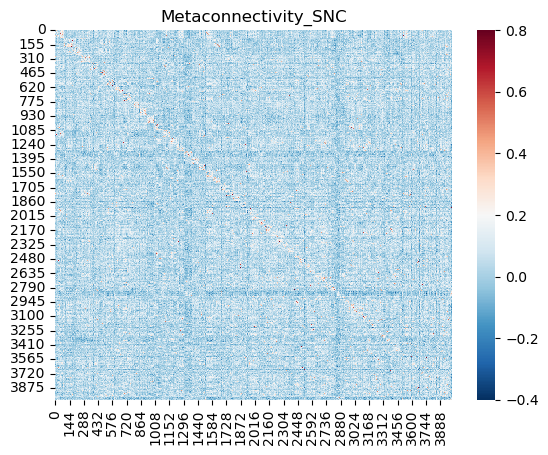

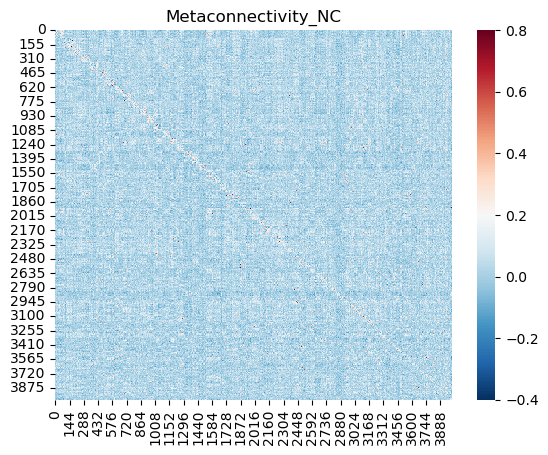

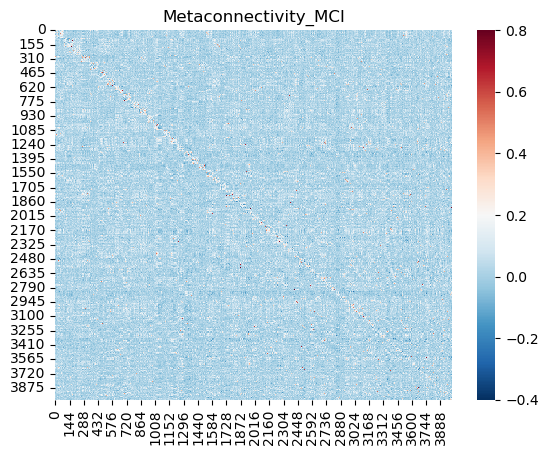

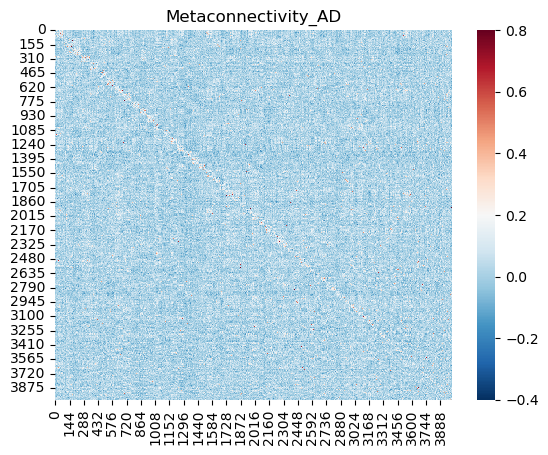

In [34]:
group_list = [SNC_meta, NC_meta, MCI_meta, AD_meta]
name_list = ['SNC', 'NC', 'MCI', 'AD']
for i in range(len(group_list)):
    sns.heatmap(group_list[i], cmap='RdBu_r', vmin=-0.4, vmax = 0.8)
    plt.title(f'Metaconnectivity_{name_list[i]}')
    plt.show()

In [31]:
# build the network based on df_MC
def build_network(mean_MC, threshold = 0.1):
    G = nx.Graph()
    for i in range(len(mean_MC)):
        for j in range(len(mean_MC)):
            if mean_MC[i,j] > threshold or mean_MC[i,j] < -threshold:
                G.add_edge(meta_links[i], meta_links[j], weight=mean_MC[i,j])
    return G
# build the network
G = build_network(AD_meta, threshold=0.1)
# # relabel the nodes with meta_links
# G = nx.relabel_nodes(G, dict(zip(range(np.shape(meta3d)[0]), meta_links)))


In [32]:
nx.write_gml(G, 'fc_network.gml')

In [33]:
print(G.number_of_nodes())
print(G.number_of_edges())

4005
727981
